# Treatment Effect
1. What is a treatment effect? Treatment effect refers to the effect of a treatment on outcome on a response of interest independent of any other factors that may influence the outcome.

2. How to control for confounders in causal inference ?

Remove from the true treatment effect of any other influences that are correlated with d, the treatment dummy, by including them in regression.

# Regression Discontinuity Design

**Definition:**

Regression Discontinuity Design (RDD) is a quasi-experimental research design that is used to estimate the causal effect of a treatment or intervention. It is used when assignment to the treatment group is based on a predetermined threshold (running variable), such as a score on a test or a certain age. The idea is that individuals just above and just below the threshold are similar in all other respects, except for their treatment status. By comparing outcomes for these two groups, researchers can estimate the causal effect of the treatment.

**Limitation:**

- **Assignment Bias**: RDD requires a clear and credible assignment mechanism for treatment and control groups, which may not always be present.
- **Local Average Treatment Effect**: RDD is only capable of estimating the average treatment effect within the bandwidth surrounding the cutoff, but may not generalize to other populations. 
- **Non-Random Assignment**: RDD assumes that assignment to treatment is based on the score near the cutoff, but other factors could influence assignment, leading to bias.

**What might be the effect of choosing a smaller bandwidth? What if we chose the maximum bandwidth in regression discontinuity design ?**

In the context of Regression Discontinuity Design (RDD), bandwidth refers to the width of the interval or window used to identify the discontinuity in the treatment assignment.

Choosing a **smaller bandwidth in RDD** can result in more precision in the estimates of the treatment effect near the discontinuity, but may also result in a larger bias due to the limited sample size. This is because a smaller bandwidth reduces the number of observations included in the analysis, which can lead to increased variability and potential bias in the estimation of the treatment effect.

On the other hand, choosing the **maximum bandwidth in RDD** can result in a larger sample size and less bias in the estimation of the treatment effect, but may also result in less precision in the estimates near the discontinuity. This is because a wider bandwidth includes more observations in the analysis, which can lead to reduced variability but may also result in a dilution of the treatment effect due to the inclusion of observations that are less affected by the treatment.

In general, the optimal bandwidth size in RDD depends on the specific context and the underlying data generating process. Researchers may need to balance the trade-offs between bias and precision in the estimation of the treatment effect, and choose a bandwidth size that provides an appropriate balance between these factors. It is also important to conduct sensitivity analyses to assess the robustness of the results to different bandwidth sizes and to test the sensitivity of the findings to other model specifications.

**Sample Code:**

The task is to analyze the drinking.csv dataset using RDD and determine whether drinking alcohol increases the chances of death by accident, suicide, and other causes for individuals above and below the age threshold of 21. The analysis should involve calculating the difference between the average chances of death for each group. Based on the results, the question of whether the legal age for drinking should be reduced from 21 should be discussed. Additionally, graphs should be plotted to visualize any discontinuities and changes in the chances of death for each feature across the age threshold. The bandwidth for the analysis should be set at 1 year. The effects of choosing a smaller or maximum bandwidth should also be discussed.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [3]:
drink = pd.read_csv('/Users/crystal/Desktop/RDD/drinking.csv')
drink = drink.dropna(axis = 0, how = 'any')
drink.head()

,age,others,accident,suicide
0,19.068493,92.825401,35.829327,11.203714
1,19.150684,95.100739,35.639256,12.193368
2,19.232876,92.144295,34.205650,11.715812
3,19.315069,88.427757,32.278957,11.275010
4,19.397261,88.704941,32.650967,10.984314


In [4]:
# As the bandwidth is set to be 1, so we filter out the data we will focus on, merely, observations with age between 20 to 22.
df = drink[(drink["age"] >= 20) & (drink["age"] <= 22)]

In [5]:
# Others 
np.mean(df['others'][df['age'] >= 21]) - np.mean(df['others'][df['age'] < 21])

6.5416600833333405

In [6]:
# Accident 
np.mean(df['accident'][df['age'] >= 21]) - np.mean(df['accident'][df['age'] < 21])

1.3384858333333405

In [7]:
# Suicide
np.mean(df['suicide'][df['age'] >= 21]) - np.mean(df['suicide'][df['age'] < 21])

1.7190783333333357

<Figure size 576x576 with 0 Axes>

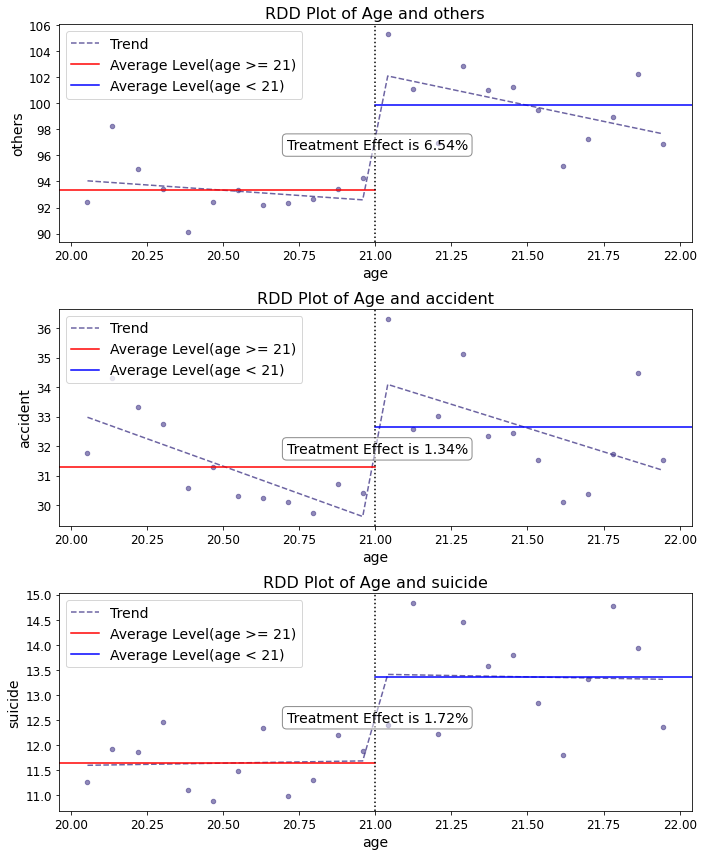

In [11]:
## Build RDD dataframe by adding "threshold" to the original dataset 
rdd_df = drink.assign(threshold=(df["age"] > 21).astype(int))
plt.figure(figsize=(8,8))

fig = plt.figure(figsize=(10, 12))
for p, cause in enumerate(["others", "accident", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    df.plot.scatter(x="age", y=cause, ax=ax, color = 'darkslateblue', alpha=0.6)
    
    m = smf.wls(f"{cause}~age*threshold", rdd_df).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    df.assign(predictions=m.fittedvalues).plot(x="age", y="predictions", ax=ax, color= "darkslateblue",  linestyle='--', alpha = 0.8,label='Trend')       
    
    below21_mean = np.mean(df[cause][df['age'] < 21])
    above21_mean = np.mean(df[cause][df['age'] >= 21])          
    plt.axhline(xmin=0, xmax=0.5, y= below21_mean, color='red', linestyle='-', label='Average Level(age >= 21)')
    plt.axhline(xmin=0.5, xmax=1, y= above21_mean, color='blue', linestyle='-', label='Average Level(age < 21)')
    
    gap = round((above21_mean - below21_mean),2)
    gap_pct = round((below21_mean - above21_mean)/min(below21_mean,above21_mean)* 100,2)
    y_pos = (abs(below21_mean + above21_mean) / 2 - min(df[cause])) / (max(df[cause]) - min(df[cause]))
    plt.annotate(f"Treatment Effect is {gap}%", (0.36, y_pos), xycoords='axes fraction', fontsize = 14,
                bbox= dict(boxstyle="round", fc = 'w', ec = '0.1', alpha=0.5))                  
    
    plt.axvline(x=21, color='black', linestyle=':')
    plt.legend(loc='best', fontsize=14)
    ax.set_xlabel("age", fontsize=14)
    ax.set_ylabel(cause, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.title(f"RDD Plot of Age and {cause}", fontsize = 16)

plt.tight_layout()
plt.show();

**Comment:**

1. Does alcohol increase the chances of death by accident, suicide and/or others (the three given columns) ?

We can tell that alcohol tend to increases the chance of death by accident, suicide and/or others based on the fact that people who are 21 age larger, in other words, who are legally allowed to drink, tend to have higher chance of death by accident, suicide and/or others.

2. Comment on the question “Should the legal age for drinking be reduced from 21?” based on the results

Even when we currently set legal age for drinking to be 21, alcohol tend to increases the chances of death, this suggests that even people are of 21 years old cannot performly well under the permission of alcohol. Therefore, we cannot be confident to set the legal age for drinking to be yonger than 21, this may post more risks to the society and young people, because younger people are expected to have lower ability of perform well than those older than them.

3. What might be the effect of choosing a smaller bandwidth? What if we chose the maximum bandwidth?

Choosing a smaller bandwidth might lead to a more precise estiamtion of treatment effect, as the observations near the cutoff point are expected to be more similar and to provide a more reliable estimate; Besides, when we have a smaller bandwidth, there are smaller number of observations for RDD, therefore, the observed treatment effect may be of lower external validity as the sample size is too small.

If we choose the maximum bandwidth, firstly, the estimate of treatment effect may not be valid at this point of time, as validity of RDD is built on the assumption that observations that are close to the threshold is similar enough to each other, observations in wider bandwidth may be very different; secondly, the estimate of treatment effect can be affected by more confounders, in other words, we are less likely to estimate a pure treatment effect.